In [16]:
from pathlib import Path

THIS = Path(".")
BASE = THIS / ".."
BASE = BASE.absolute().resolve()

MODEL = BASE / "model"
EXPORTS = BASE / "exports"

MODEL_NAME="Llama-2-7b-hf"

MODEL_PATH = MODEL / MODEL_NAME
EXPORTS = EXPORTS / MODEL_NAME


## Quant

## Transformers

In [17]:
METHOD = "quant/hf"
METHOD_EXPORTS = EXPORTS / METHOD


In [18]:
# print paths
print("BASE:", BASE)
print("MODEL:", MODEL)
print("MODEL_PATH:", MODEL_PATH)
print("METHOD_EXPORTS:", METHOD_EXPORTS)

BASE: /home/shwu/LLM-Efficiency-Survey
MODEL: /home/shwu/LLM-Efficiency-Survey/model
MODEL_PATH: /home/shwu/LLM-Efficiency-Survey/model/Llama-2-7b-hf
METHOD_EXPORTS: /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/quant/hf


In [19]:
# hf quant model sizes
hf_quant_models = [x for x in METHOD_EXPORTS.iterdir() if x.is_dir()]
hf_quant_models.append(MODEL_PATH)

AWQ_EXPORTS=EXPORTS / "quant/awq"
awq_models = [x for x in AWQ_EXPORTS.iterdir() if x.is_dir()]
hf_quant_models.extend(awq_models)

for model in hf_quant_models:

    # model_size := size of output.safetensors or <model>.p
    model_size = sum([x.stat().st_size for x in model.glob("*.safetensors")])
    print(f"{model.name}: {model_size / (1024 ** 3):.2f} GiB")

gptq_3: 2.87 GiB
gptq_8: 6.67 GiB
gptq_2: 2.11 GiB
gptq_4: 3.63 GiB
Llama-2-7b-hf: 12.55 GiB
gemm: 3.62 GiB
gemv: 3.62 GiB


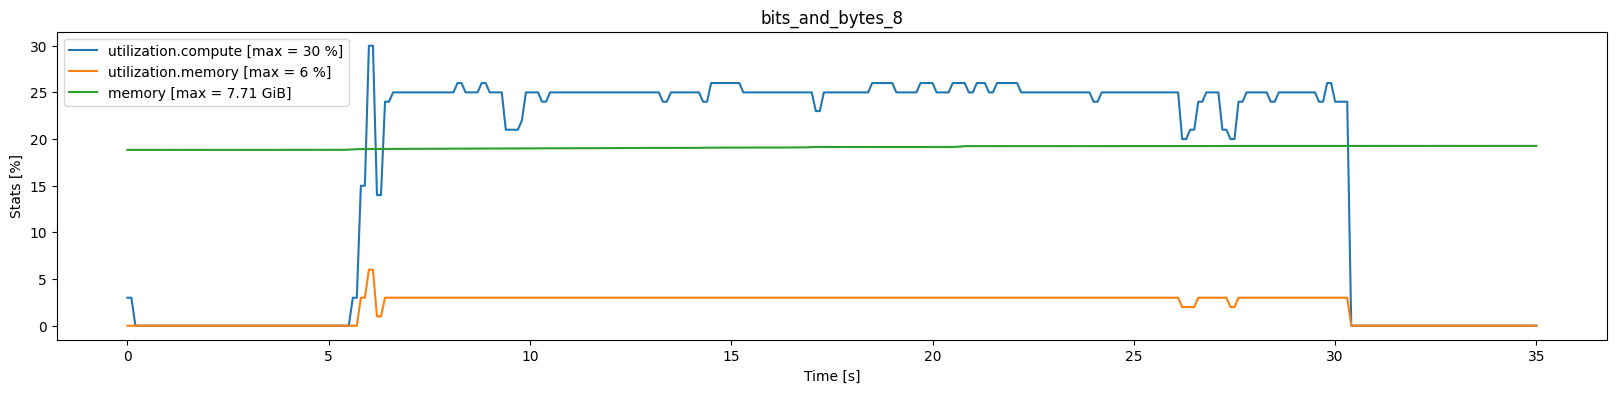

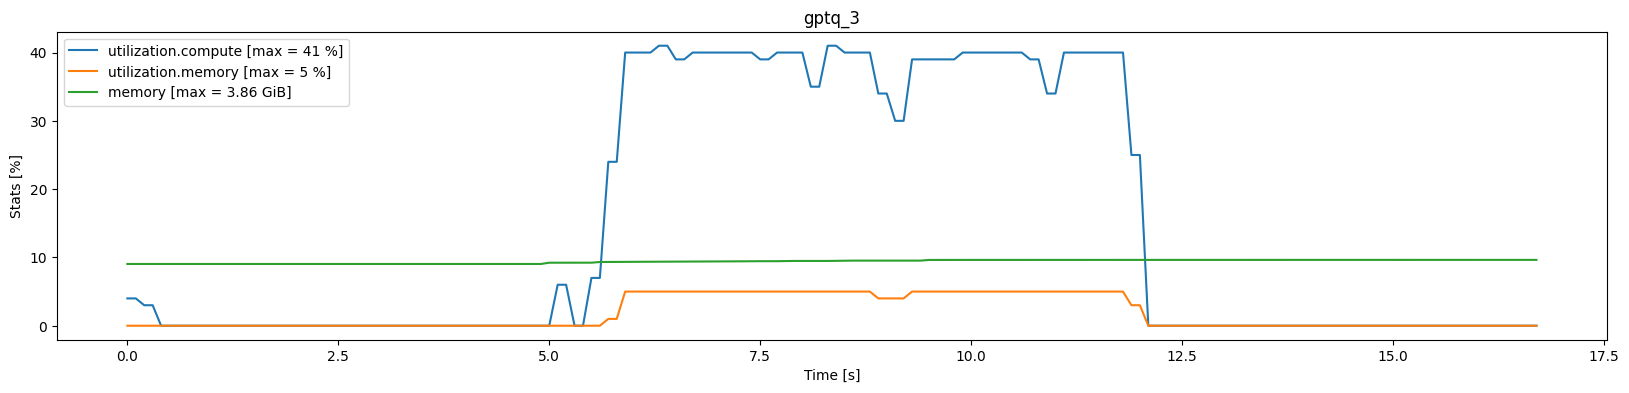

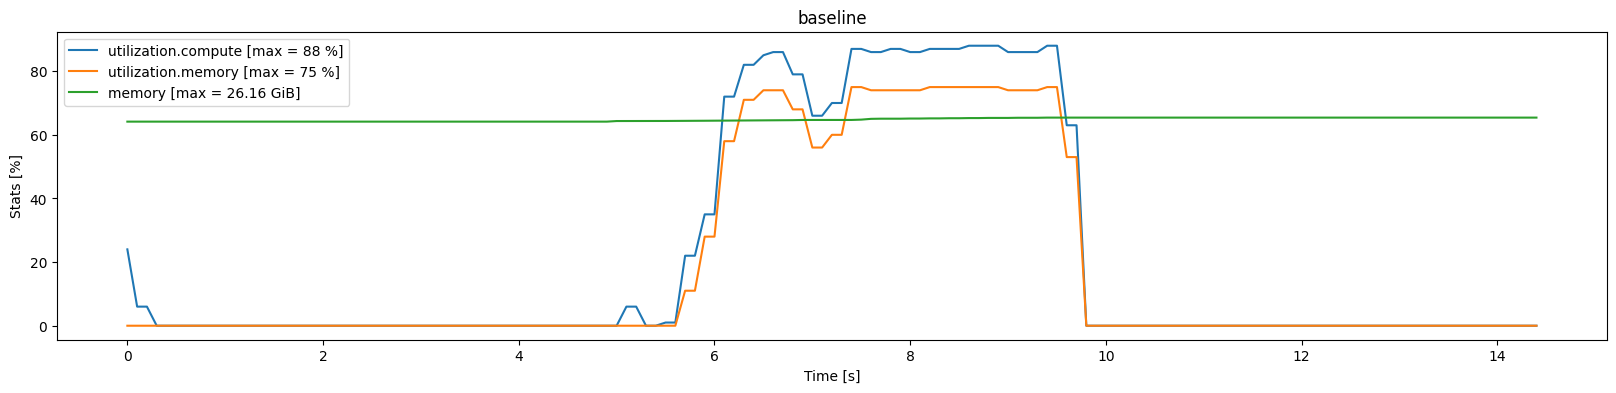

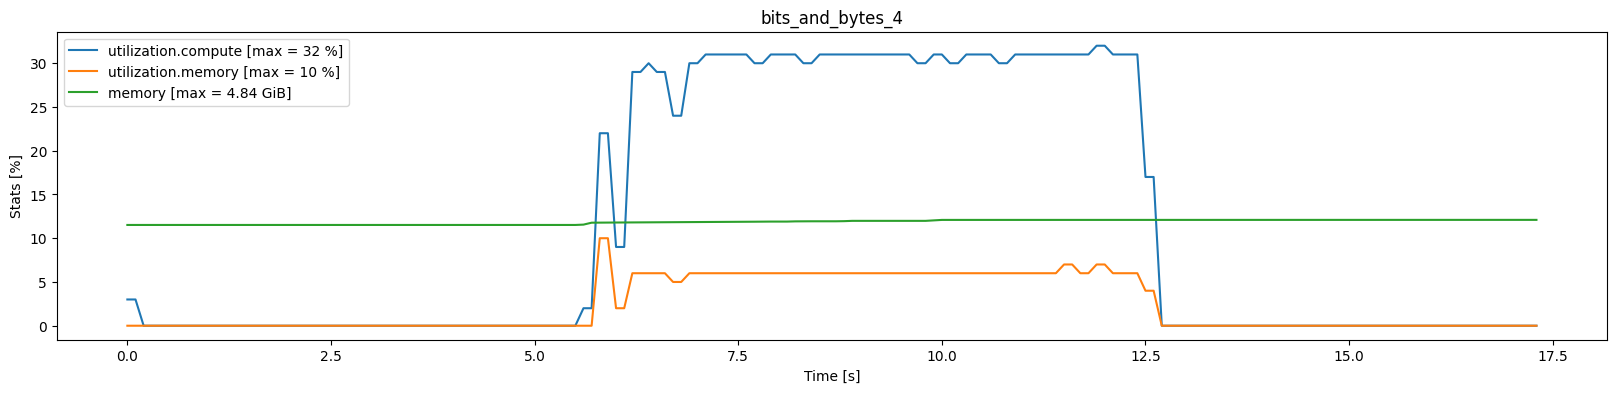

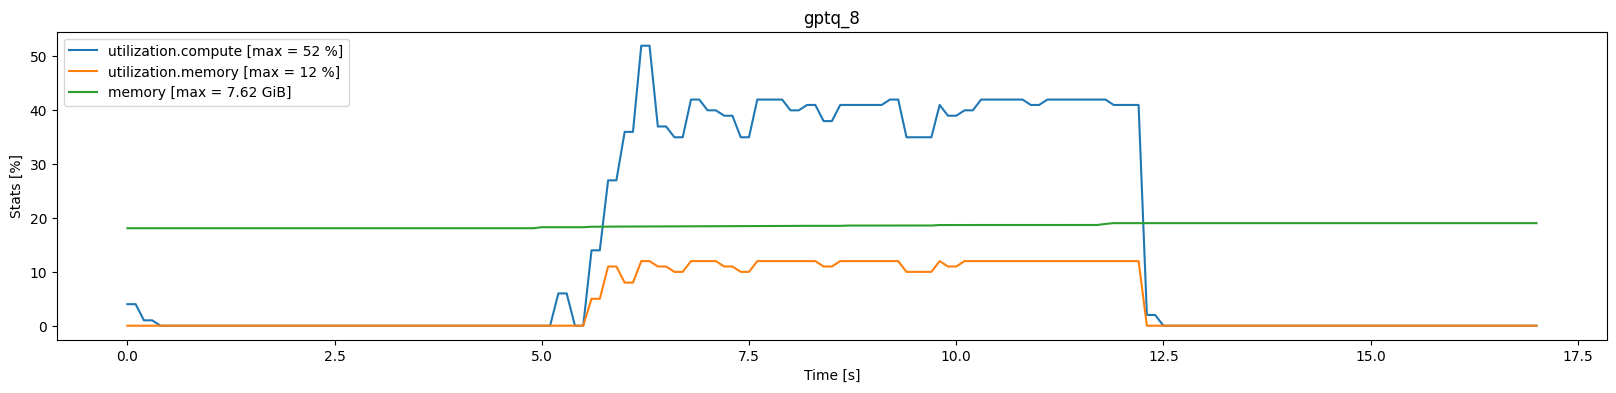

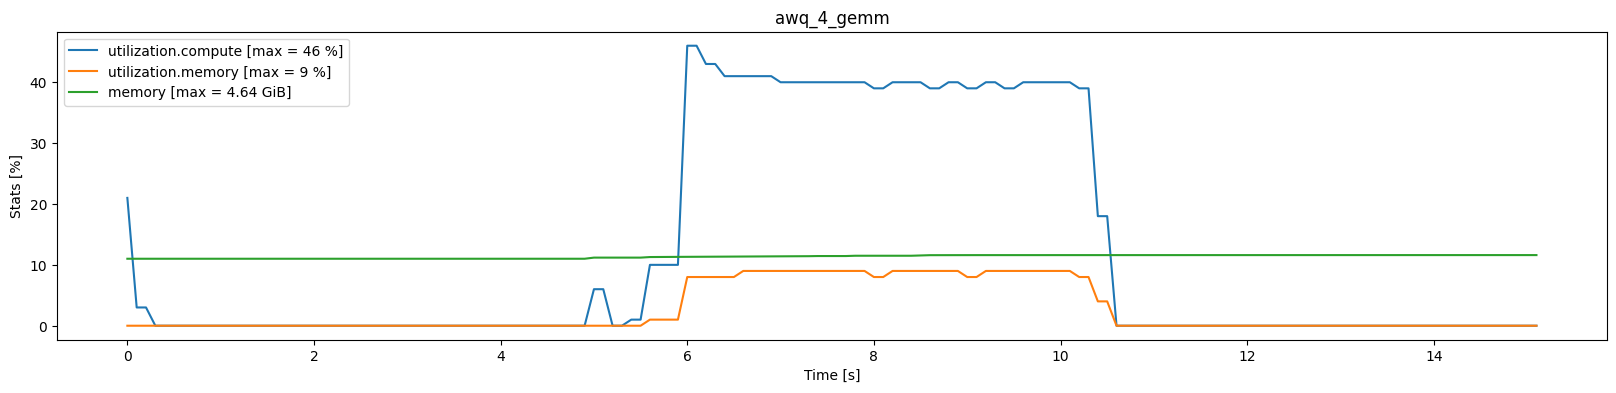

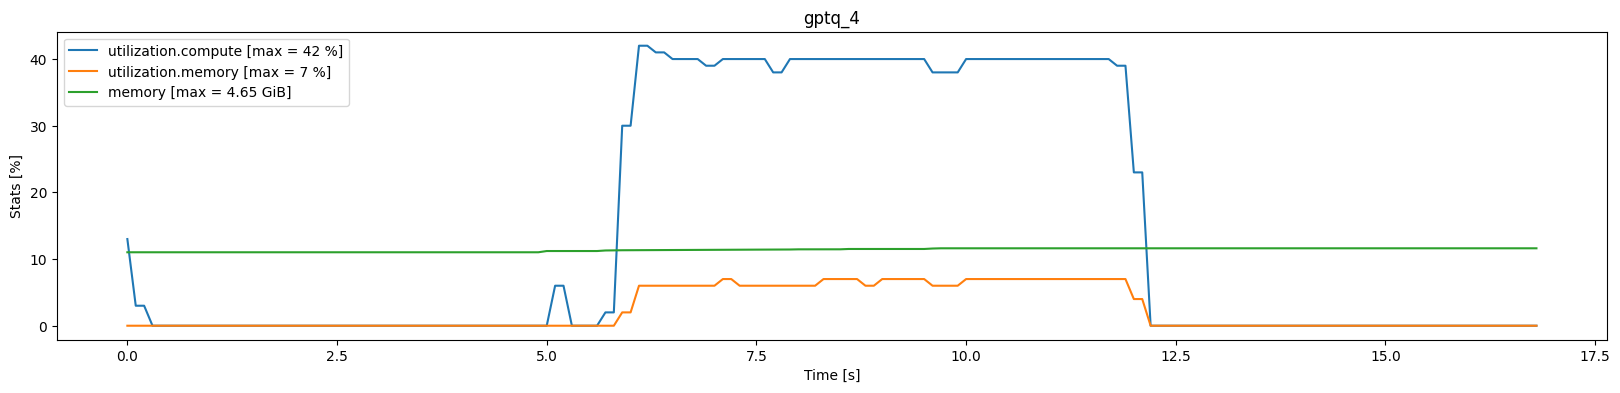

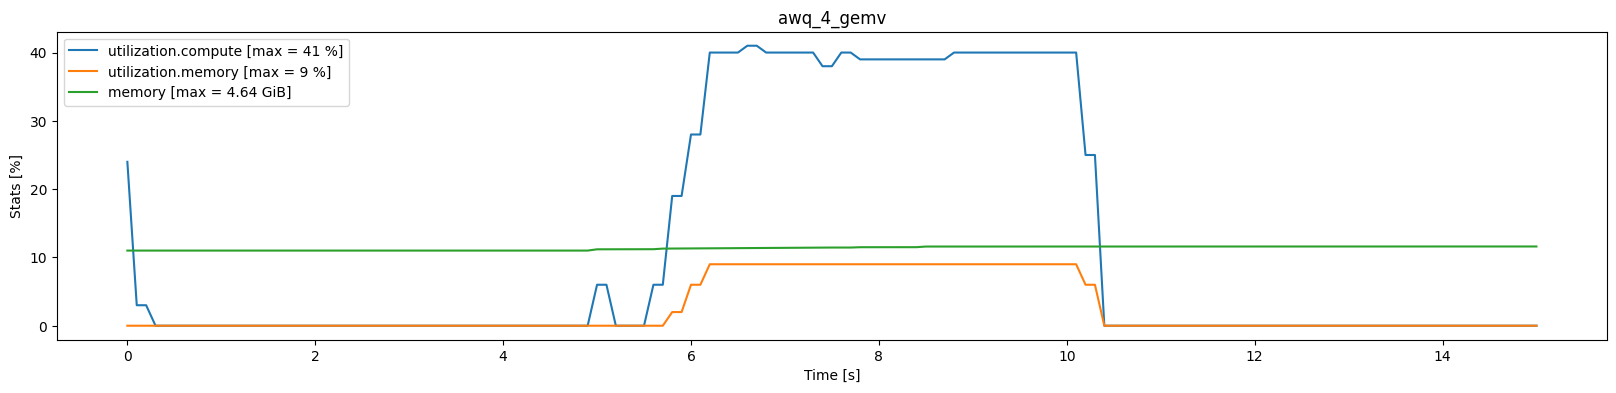

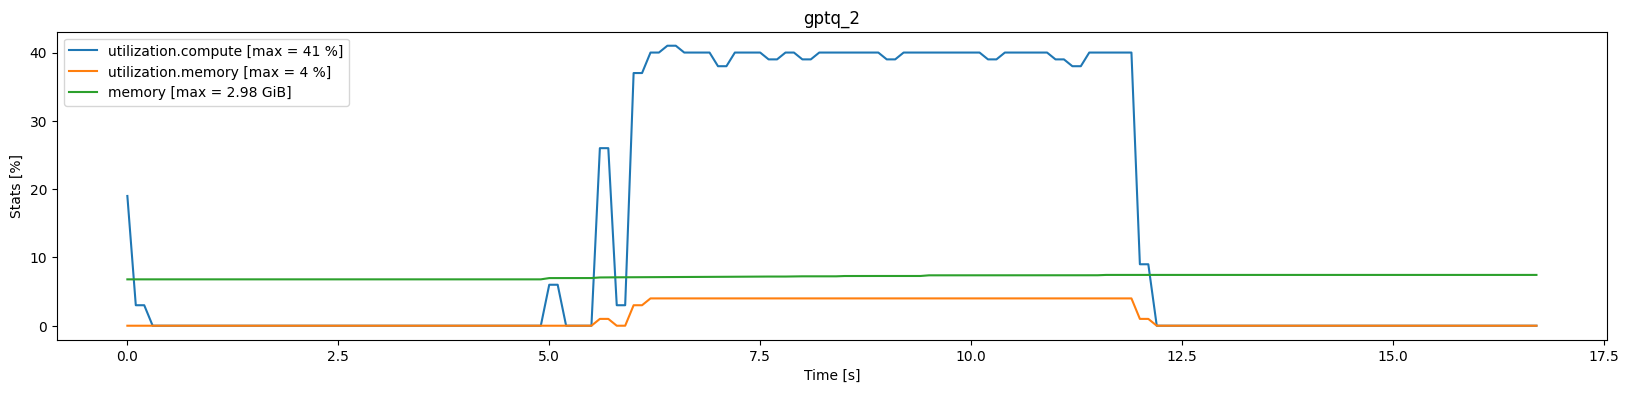

In [20]:
# max mem usage
import pandas as pd
import matplotlib.pyplot as plt
all_csvs = list(METHOD_EXPORTS.glob("*.csv"))

# csv header
# utilization.gpu [%], utilization.memory [%], memory.used [MiB], memory.free [MiB], memory.total [MiB]
utlization_gpu_key = "utilization.gpu [%]"
utilization_memory_key = " " + "utilization.memory [%]"
memory_used_key = " " + "memory.used [MiB]"
memory_free_key = " " + "memory.free [MiB]"
memory_total_key = " " + "memory.total [MiB]"

for csv in all_csvs:
    if not "bench" in csv.name:
        continue
    df = pd.read_csv(csv)

    # plot csv of utilization.memory [%] and utilization.gpu [%] both on y-axis
    fig, ax1 = plt.subplots(figsize=(20, 4))
    plt.title(csv.name.split('usage')[-1][1:-4])
    ax1.set_ylabel("Stats [%]")
    ax1.set_xlabel("Time [s]")
    ax1.plot(df.index * 0.1, df[utlization_gpu_key], label=f"utilization.compute [max = {df[utlization_gpu_key].max()} %]")
    ax1.plot(df.index * 0.1, df[utilization_memory_key], label=f"utilization.memory [max = {df[utilization_memory_key].max()} %]")
    ax1.plot(df.index * 0.1, (df[memory_used_key] / df[memory_total_key]) * 100, label=f"memory [max = {df[memory_used_key].max() / 1024:.2f} GiB]")
    ax1.legend(loc="upper left")

In [22]:
# benchmark logs
all_logs = list(METHOD_EXPORTS.glob("*.log"))

for log in all_logs:
    if not "bench" in log.name:
        continue

    print(f"{log.name.replace('_', ' ')[:-4]}")
    with open(log) as f:
        lines = f.readlines()
    print(f"{lines[-4]}")

bench 2
Generated 128 tokens in 5.370797157287598 seconds (23.832588766886808 tokens/s)

bench baseline
Generated 128 tokens in 4.647922515869141 seconds (27.53918542380532 tokens/s)

bench 4
Generated 128 tokens in 6.927386522293091 seconds (18.47738675878442 tokens/s)

bench 7
Generated 128 tokens in 7.2449281215667725 seconds (17.667532079299498 tokens/s)

bench 5
Generated 128 tokens in 6.916422128677368 seconds (18.50667839796492 tokens/s)

bench 0
Generated 128 tokens in 7.525451898574829 seconds (17.008945339779615 tokens/s)

bench 1
Generated 128 tokens in 25.527113676071167 seconds (5.014276256386392 tokens/s)

bench 6
Generated 128 tokens in 7.052340269088745 seconds (18.15000341957965 tokens/s)

bench 3
Generated 128 tokens in 5.202446699142456 seconds (24.60380805460224 tokens/s)

